# Overview
Kickstarter is a crowdfunding site where anyone can start campaigns to receive funding from the general public for their creative projects. The site has an interesting dynamic because the creator only receives the funding if and when they reach their specified funding goal in their specified amount of time. So creators have to set a funding goal high enough to sufficiently fund their project but low enough to be achievable. They have to set a deadline far enough to reach their goal but close enough so they don't have to wait long to use the money. In this data analysis, we're going to explore what subtle factors could contribute to the success of a campaign and try to extract tips that can help you fund your own projects.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ks = pd.read_csv("ks-projects-201801.csv")
ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01 03:43:57,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0


By graphing main category on a count plot with a hue of state, we can see if and how success rates differ between the different project categories.

Text(0.5,1,'Number of projects in each category (by status of project)')

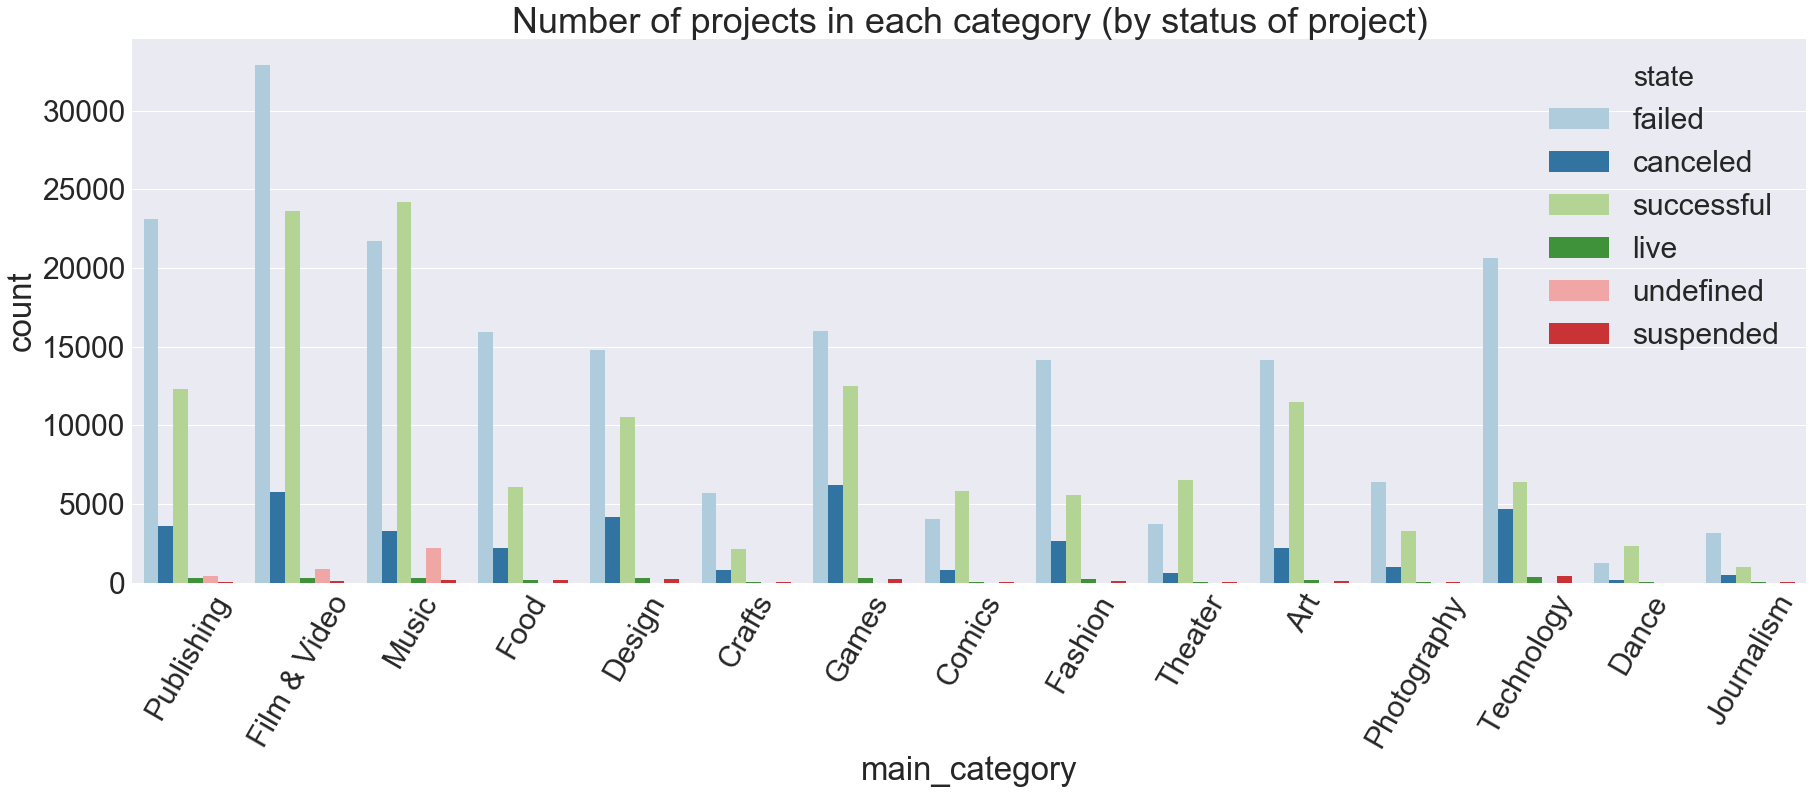

In [3]:
plt.figure(figsize=(30,10))
sns.set(font_scale=3)
sns.countplot(x='main_category', data=ks, hue="state", palette="Paired")
plt.xticks(rotation=60)
plt.title("Number of projects in each category (by status of project)")

It looks like the success rates definitely differ based on the category. For example, music projects seem to fair pretty well while technology projects fail more often. We can delve more into the reasons behind these differences. For example, do tech projects fail more because they tend to have higher funding goals, or is there something inherent that contributes to lower success rates?

First of all, we're going to drop projects from the data set that have a state of live, undefined, or suspended. These states seem too ambiguous to consider a success or failure. For the sake of this analysis, I'm also going to consider a canceled project a failure because in the majority of cases, a canceled project means that the creator did not believe they would reach their goal.

In [4]:
ks.drop(ks[(ks.state == "live") | (ks.state == "undefined") | (ks.state == "suspended")].index, inplace=True )

In [5]:
def success(state):
    if state == "successful":
        return 1
    else:
        return 0
    
ks["successful"] = ks["state"].apply(success)

Text(0.5,1,'Number of projects in each category (by status of project)')

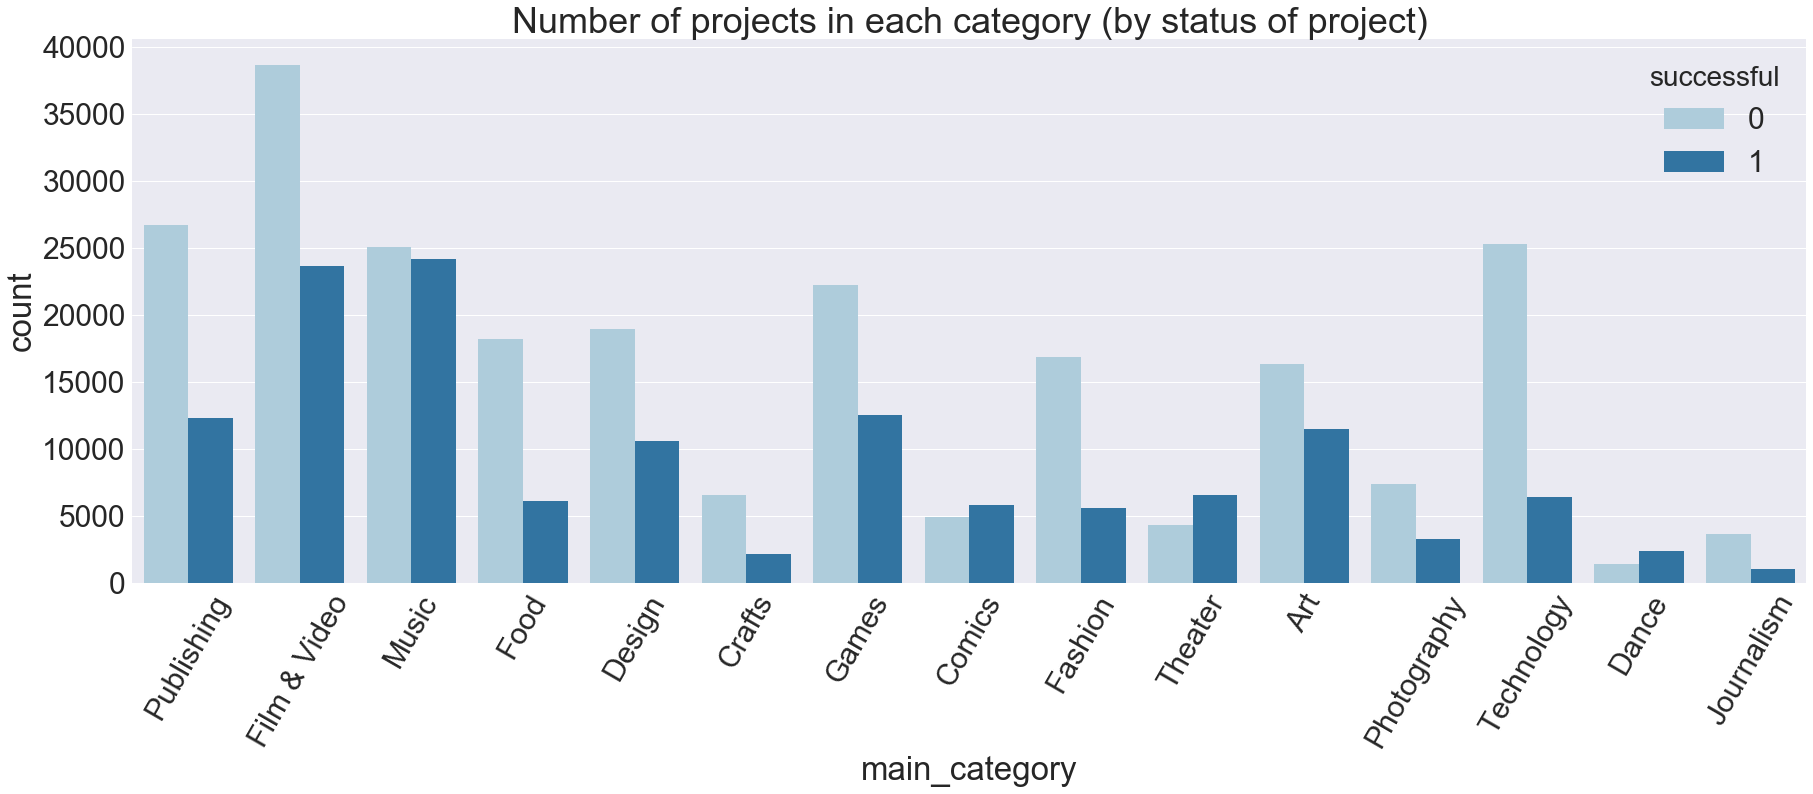

In [6]:
plt.figure(figsize=(30,10))
sns.set(font_scale=3)
sns.countplot(x='main_category', data=ks, hue="successful", palette="Paired")
plt.xticks(rotation=60)
plt.title("Number of projects in each category (by status of project)")

We're also going to create a column in the data set for the funding period (in days) because the data set currently gives the launch date and the deadline date for each campaign. Projects that have a funding period exceeding 5000 days are removed from the data set because that means a period of over 13 years. Because creators only get the funds after the deadline is reached, people who have funding periods this long, I believe are either crazy or don't know how Kickstarter works.

In [7]:
fund_time = (pd.to_datetime(ks.deadline) - pd.to_datetime(ks.launched)).apply(lambda dt : dt.days + dt.seconds / (60 * 60 * 24))
ks['fund_time'] = fund_time
ks.drop(ks[ks.fund_time > 5000].index, inplace=True)

Text(0,0.5,'# of Projects')

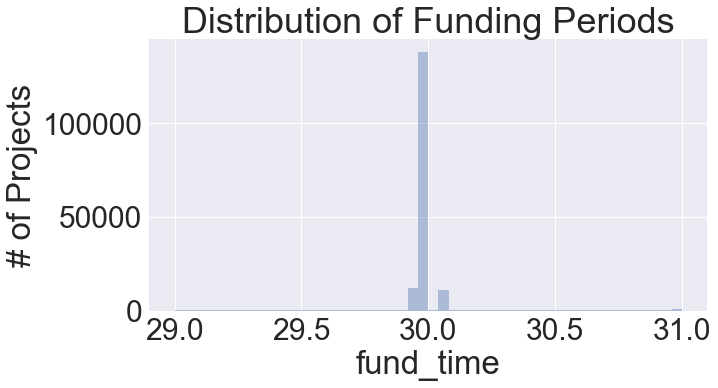

In [103]:
plt.figure(figsize=(10, 5))
sns.distplot(ks['fund_time'], kde=False)
plt.title("Distribution of Funding Periods")
plt.ylabel("# of Projects")

In [9]:
ks['fund_time'].value_counts().head()

30.000000    136667
60.000000     26518
45.000000     13709
29.958333     11276
30.041667     10717
Name: fund_time, dtype: int64

We can see that the most popular funding period is a month, which makes sense because that is the default when you create a new project on Kickstarter. Based on status quo bias, it makes sense that many people would stick to that month time frame. However, because many people choose that time frame without a reason beside it being a nice, round length of time and it being the default, I don't believe it is a good metric in determining the success of a project. As a result, it may be easier to analyze other features by keeping funding period constant, only looking at the campaigns lasting a month.

In [138]:
ks = ks[(ks['fund_time'] > 29) & (ks['fund_time'] < 31)]

## Feature: Goal

Text(0,0.5,'# of Projects')

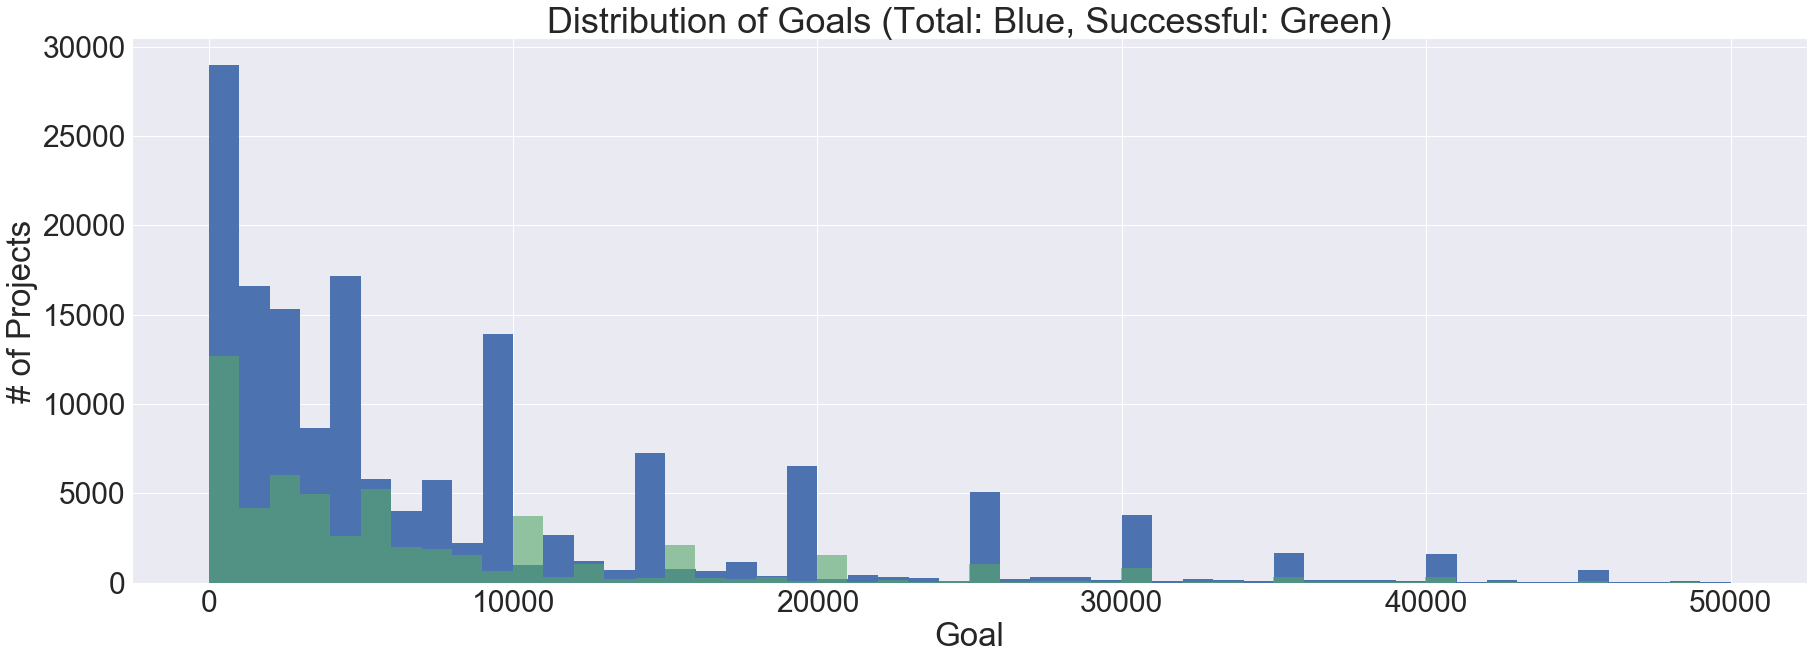

In [50]:
plt.figure(figsize=(30,10))
ks[ks.goal < 50000]['goal'].hist(bins=50)
ks[(ks.successful == 1) & (ks.goal < 50000)]['goal'].hist(bins=50, alpha=0.6)
plt.title("Distribution of Goals (Total: Blue, Successful: Green)")
plt.xlabel("Goal")
plt.ylabel("# of Projects")

Note: goal was limited to 50000 for graphing reasons

First of all, we notice the spikes in the histogram, which are most likely due to "nice" numbers like $10,000 or $15,000 being more popular. There's also a sort of exponentially decreasing trend for both the number of total campaigns and number of successful campaigns as the goal amount increases. From a quick glance, it also seems that **campaigns generally have higher success rates at lower goal values**, which makes sense because projects not asking for too much would intuitively be more successful.

Question: Why do some bins of the "successful" histogram surpass the corresponding bin of the "total" histogram? There can't be more successful projects than total projects. I think this is probably due to a difference in how the bins are split up for each histogram.

## Feature: Category

Text(0.5,1,'Category vs. Goal')

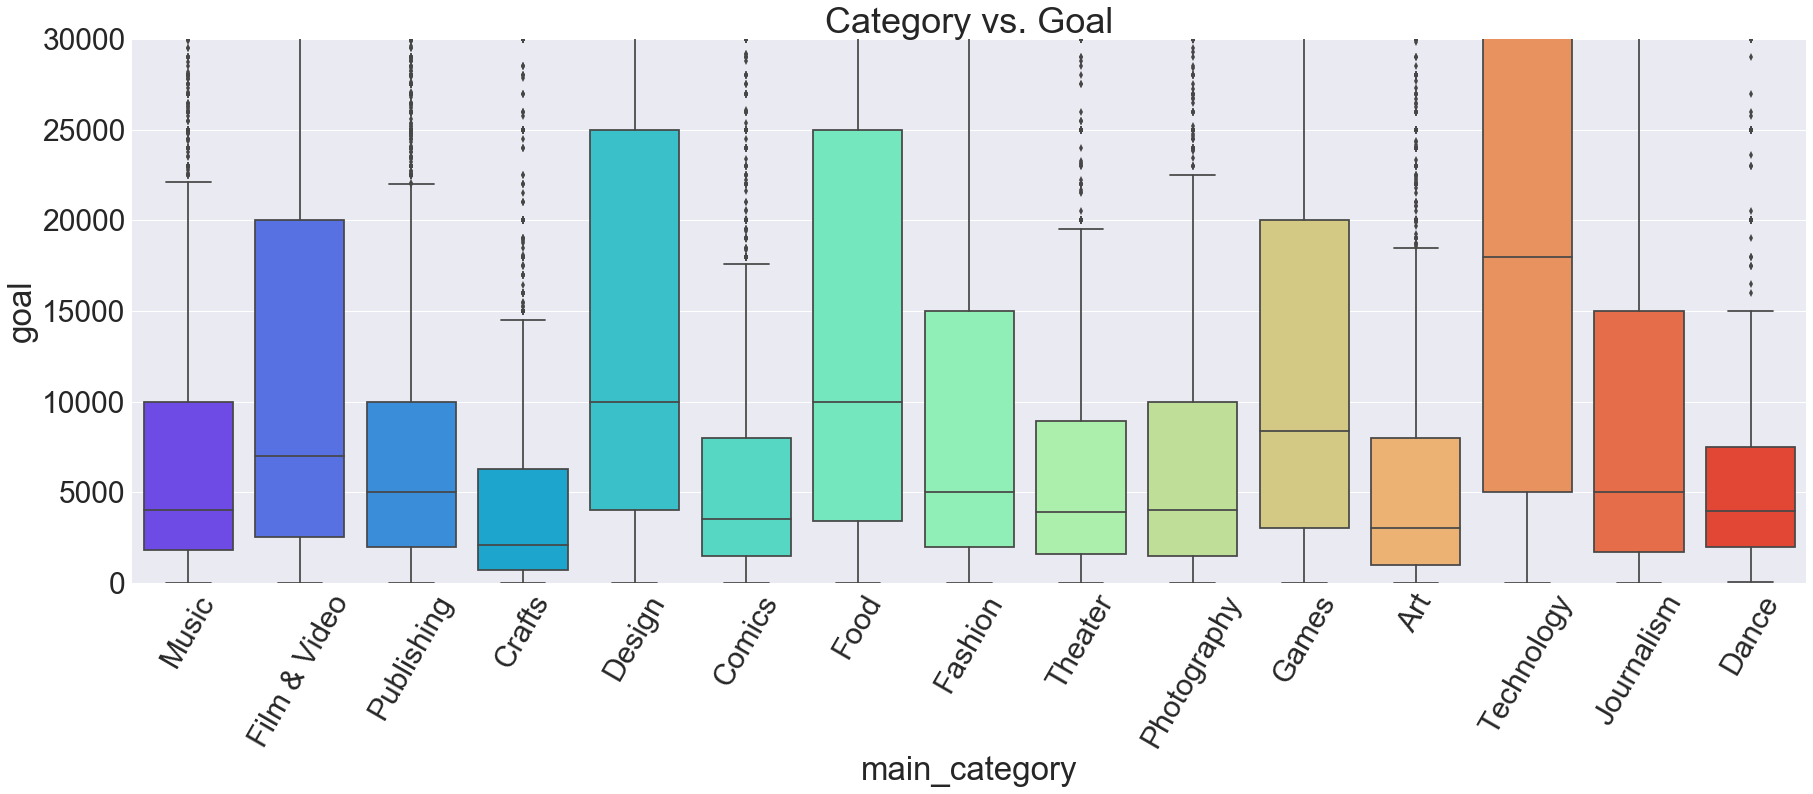

In [51]:
plt.figure(figsize=(30, 10))
sns.boxplot(x="main_category", y="goal", data=ks, palette="rainbow")
plt.ylim(0, 30000)
plt.xticks(rotation=60)
plt.title("Category vs. Goal")

I think a box plot works well for comparing category to goal because there are a lot of outliers with crazy high goal amounts, which could badly skew a graph dependent on the mean of the goals. Looking at this box plot, it's easy to visualize which categories of projects tend to have higher goal amounts. As we can see, technology generally has the highest goal values, and we saw while analyzing the goal feature, projects with higher goal values seem to have lower success rates. This result could explain some of the findings in graph Out[6].

I think now it would be interesting to compare the median goal values for the categories to the success rates for the categories as seen in graph Out[6].

In [132]:
# data frame of the median goals of the categories
cat_median = ks.groupby('main_category').median()['goal'].sort_values(ascending=False)
cat_med_df = pd.DataFrame({'main_category':cat_median.index, 'median':cat_median.values})

In [133]:
# data frame of the mean goals of the categories
cat_mean = ks.groupby('main_category').mean()['goal'].sort_values(ascending=False)
cat_mean_df = pd.DataFrame({'main_category':cat_mean.index, 'mean':cat_mean.values})

In [134]:
# series of the success rates of the categories
temp1 = ks.groupby('main_category').agg({'successful': 'sum', 'goal': 'count'})
cat_success_rate = temp1.successful / temp1.goal
sort_csr = cat_success_rate.sort_values()

Text(0.5,1,'Category vs. Median of Goals')

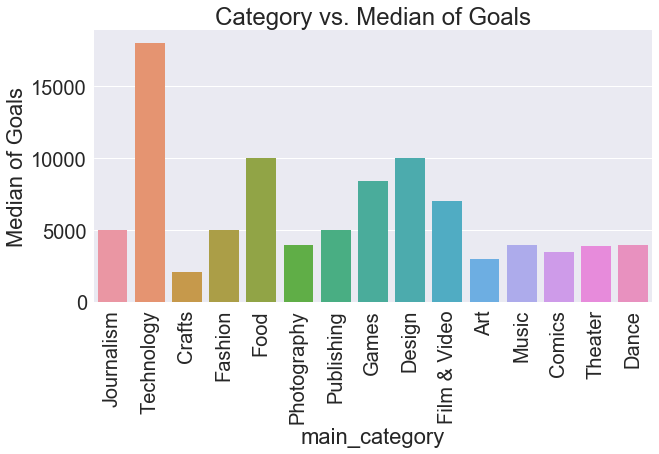

In [137]:
plt.figure(figsize = (10,5))
sns.set(font_scale=2)
sns.barplot(x="main_category", y="median", data=cat_med_df, order=['Journalism', 'Technology', 'Crafts', 'Fashion', 'Food', 'Photography',
       'Publishing', 'Games', 'Design', 'Film & Video', 'Art', 'Music',
       'Comics', 'Theater', 'Dance'])
plt.xticks(rotation=90)
plt.ylabel('Median of Goals')
plt.title('Category vs. Median of Goals')

Text(0.5,1,'Category vs. Mean of Goals')

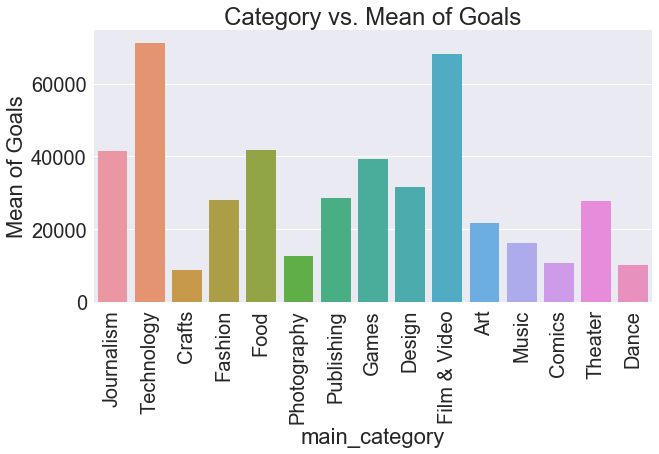

In [136]:
plt.figure(figsize = (10,5))
sns.set(font_scale=2)
sns.barplot(x="main_category", y="mean", data=cat_mean_df, order=['Journalism', 'Technology', 'Crafts', 'Fashion', 'Food', 'Photography',
       'Publishing', 'Games', 'Design', 'Film & Video', 'Art', 'Music',
       'Comics', 'Theater', 'Dance'])
plt.xticks(rotation=90)
plt.ylabel('Mean of Goals')
plt.title('Category vs. Mean of Goals')

Text(0.5,1,'Category vs. Success Rate')

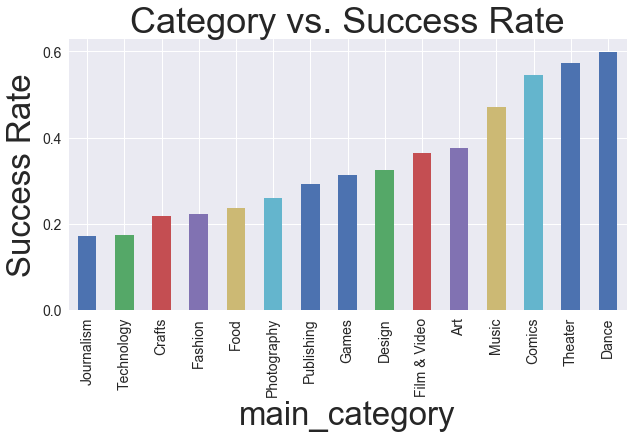

In [118]:
plt.figure(figsize = (10,5))
sort_csr.plot.bar(fontsize=14)
plt.ylabel("Success Rate")
plt.title("Category vs. Success Rate")

Note: I also analyzed category vs. mean of the goals in case it better matched the data for category vs. success rate.

So I'm actually pretty surprised. I thought that the goal category would be a better determiner of the success rates for the categories. If there was a strong relationship between the success rate and the funding goals of the category, then you would expect the bar plots for category vs. median/mean to have a decreasing trend because a lower success rate would correspond to higher funding goals for the category. However, the graphs for category vs. median/mean don't show any noticeable trends. This result doesn't mean the funding goals don't play any role in the success rates of the categories, but I believe it means that "category" is more of an independent feature for determining success than I thought.

As a result, I'm going to include the success rate rankings for the categories as a useful observation:

__Success Rate Rankings__
1) Dance
2) Theater
3) Comics
4) Music
5) Art
6) Film & Video
7) Design
8) Games
9) Publishing
10) Photography
11) Food
12) Fashion
13) Crafts
14) Technology
15) Journalism

## Feature: Title Length

We've looked at the more obvious features like category and funding goal, but I'm curious whether there are more subtle features that can influence the success of a campaign. One of these features I'm thinking about is

In [21]:
ks['title_length'] = ks['name'].apply(lambda x : len(x))

Text(0.5,1,'For many characters')

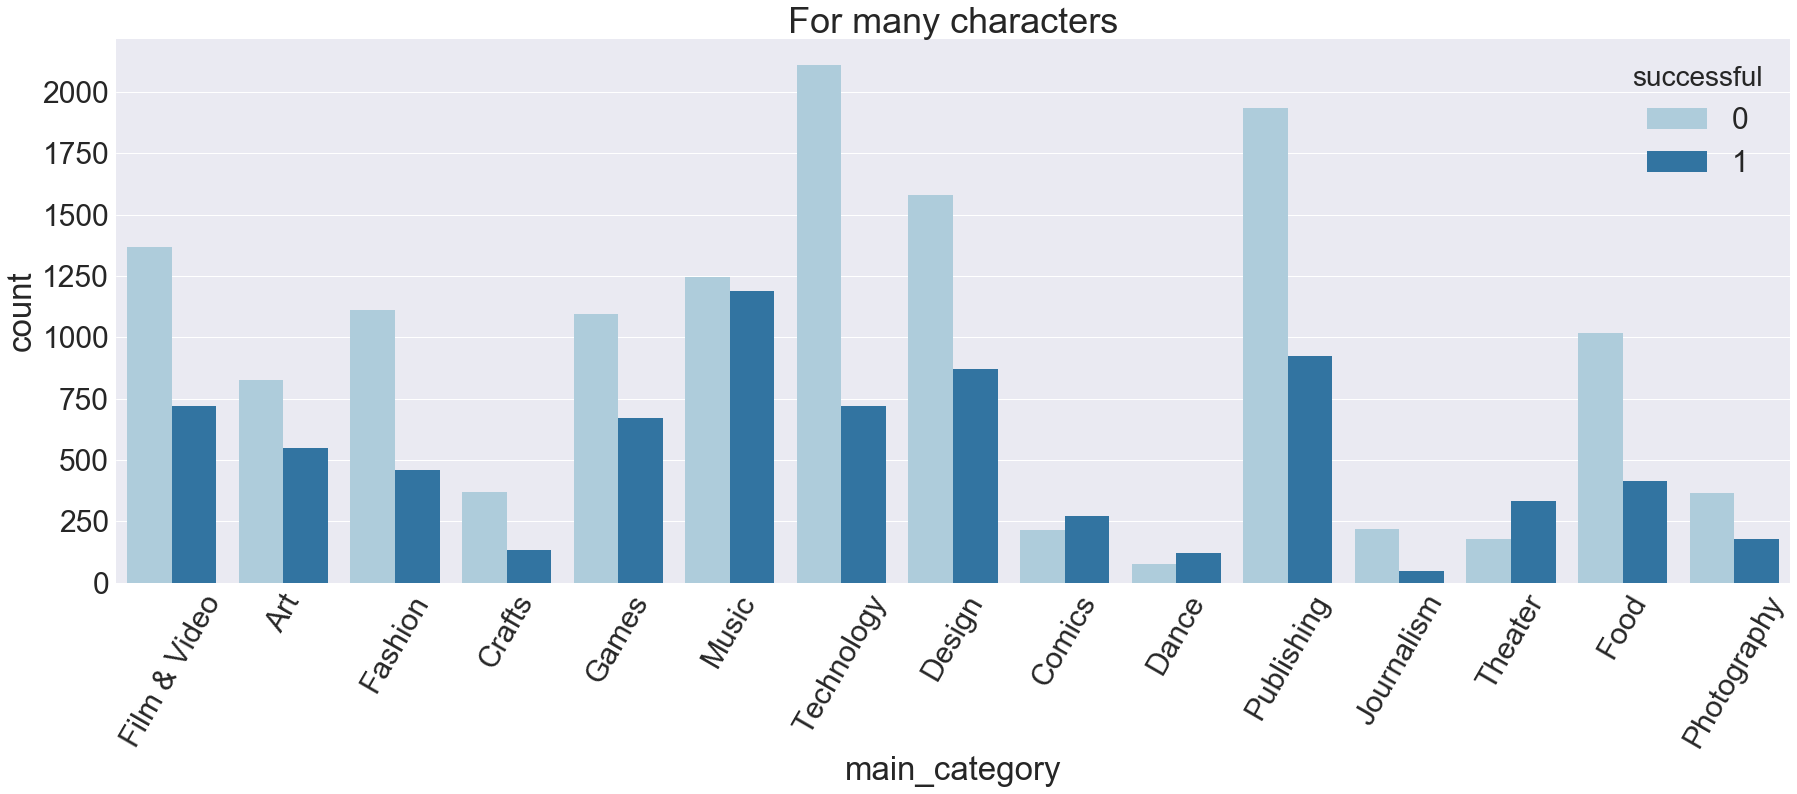

In [70]:
plt.figure(figsize=(30,10))
sns.set(font_scale=3)
ks1 = ks[(ks.title_length > 55)]
sns.countplot(x="main_category", data = ks1, hue="successful", palette="Paired")
plt.xticks(rotation=60)
plt.title("For many characters")

Text(0.5,1,'For little characters')

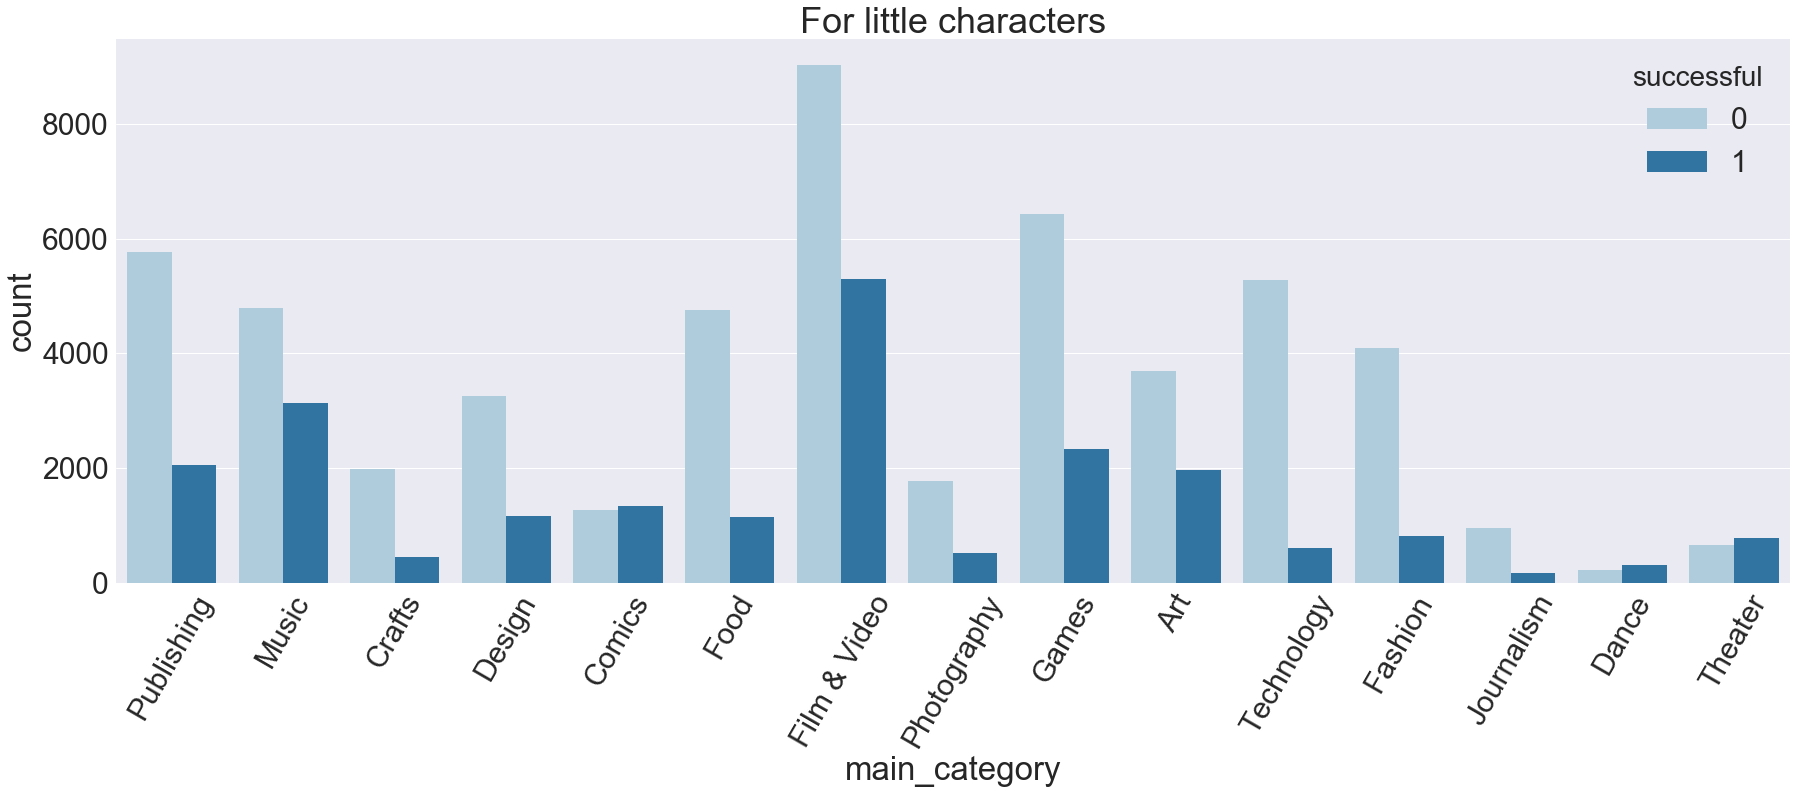

In [74]:
plt.figure(figsize=(30,10))
sns.set(font_scale=3)
ks2 = ks[(ks.title_length < 30)]
sns.countplot(x="main_category", data = ks2, hue="successful", palette="Paired")
plt.xticks(rotation=60)
plt.title("For little characters")

Text(0.5,1,'Number of projects in each category (by status of project)')

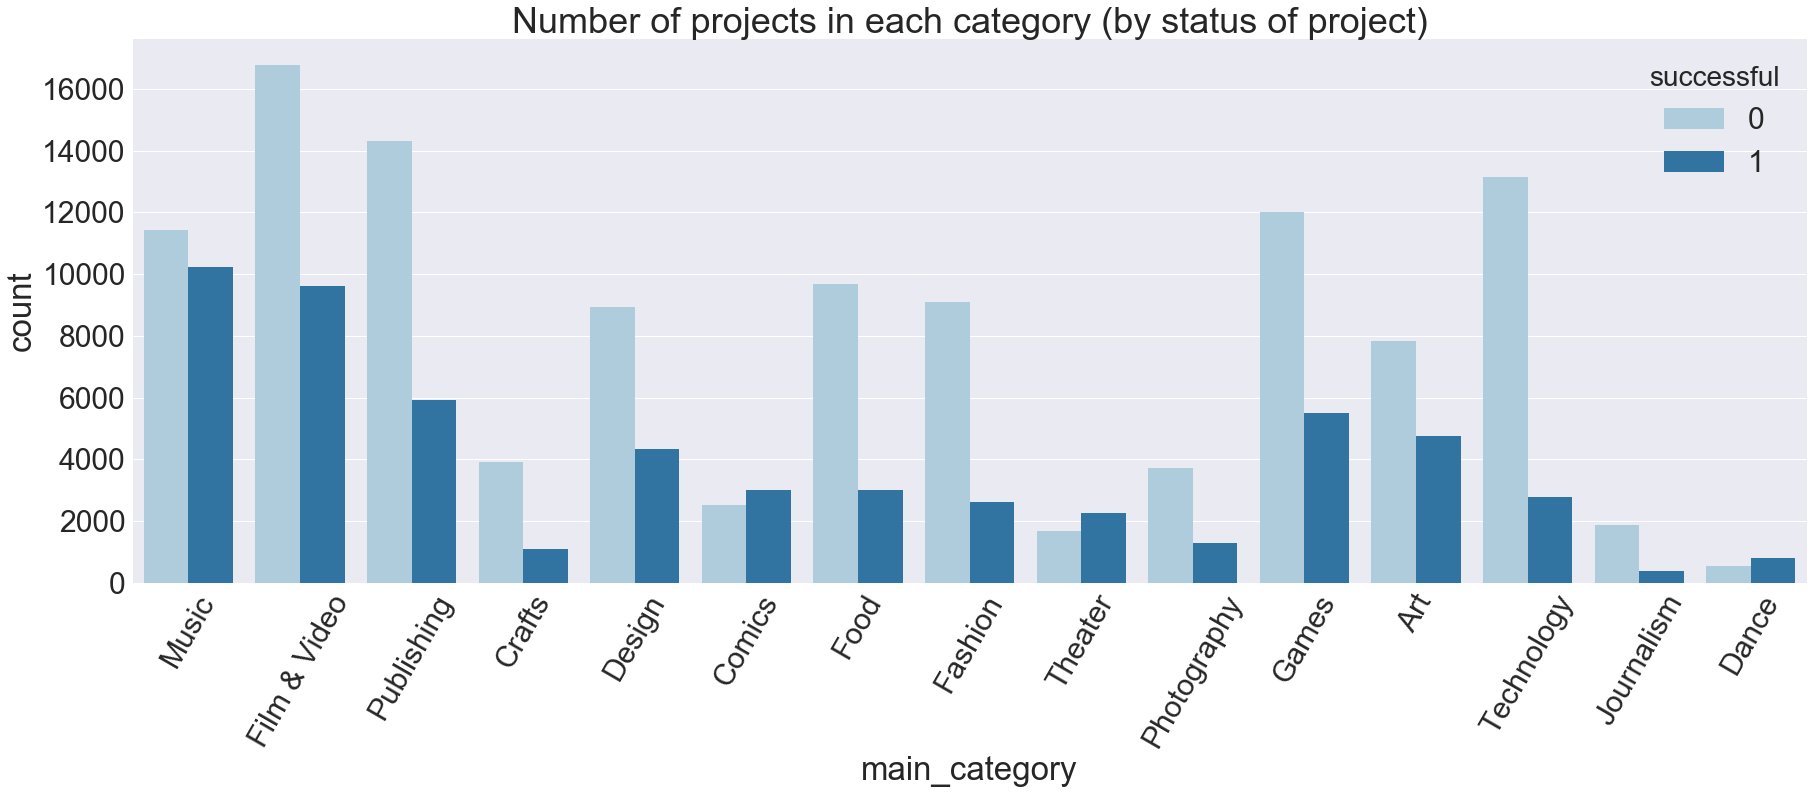

In [66]:
plt.figure(figsize=(30,10))
sns.set(font_scale=3)
sns.countplot(x='main_category', data=ks, hue="successful", palette="Paired")
plt.xticks(rotation=60)
plt.title("Number of projects in each category (by status of project)")

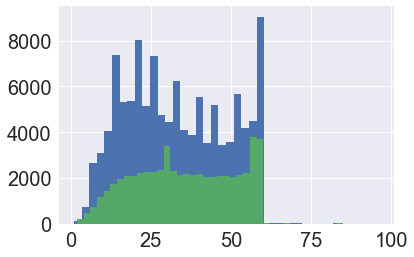

In [149]:
ks[ks.successful == 0]['title_length'].hist(bins=40)
ks[ks.successful == 1]['title_length'].hist(bins=40)

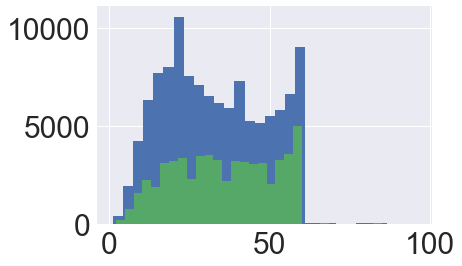

In [23]:
ks[ks.successful == 0]['title_length'].hist(bins=30)
ks[ks.successful == 1]['title_length'].hist(bins=30)

In [27]:
starting_month = (pd.to_datetime(ks.launched)).apply(lambda dt : dt.month)
ks['starting_month'] = starting_month

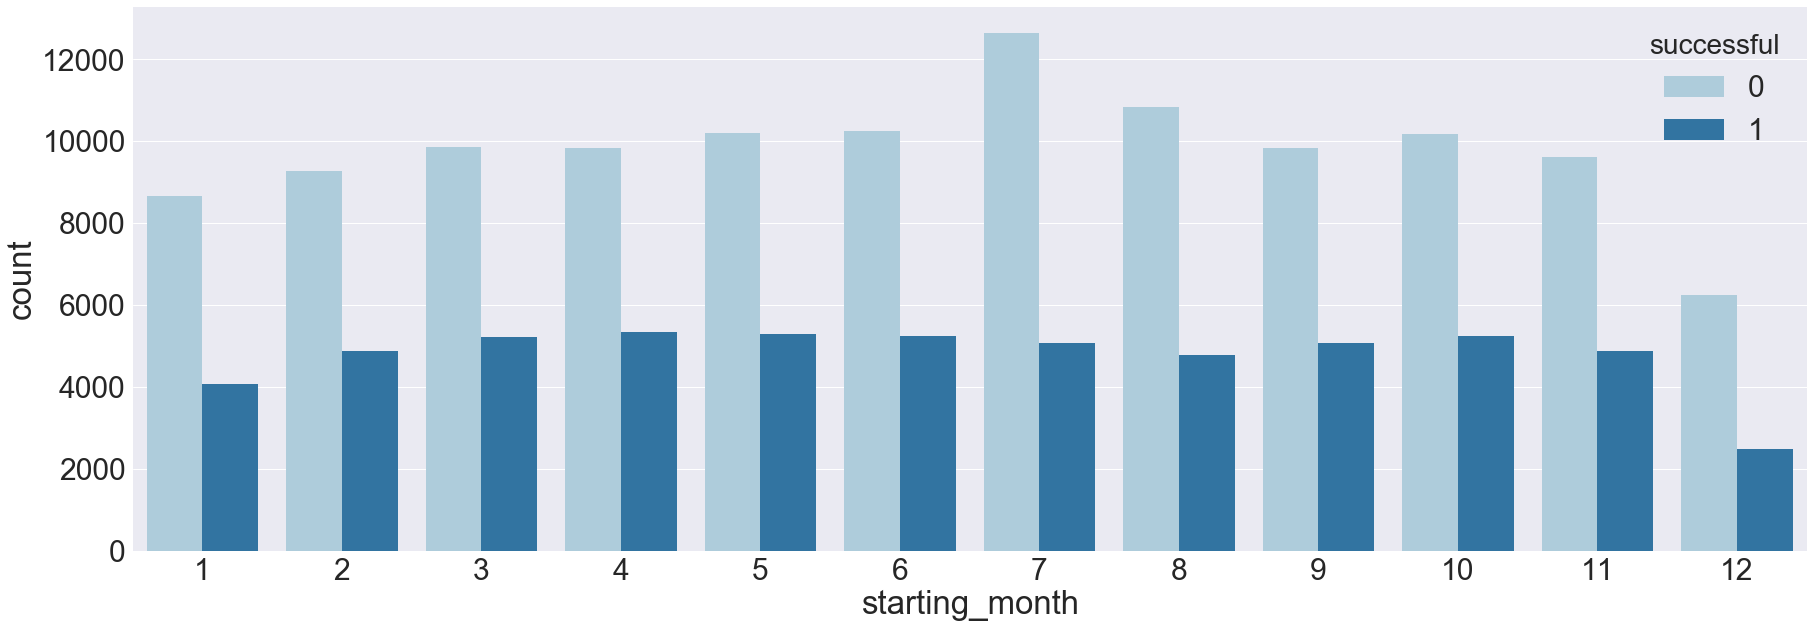

In [28]:
plt.figure(figsize=(30, 10))
sns.countplot(x='starting_month', data=ks, hue="successful", palette="Paired")

In [140]:
ending_month = (pd.to_datetime(ks.deadline)).apply(lambda dt : dt.month)
ks['ending_month'] = ending_month

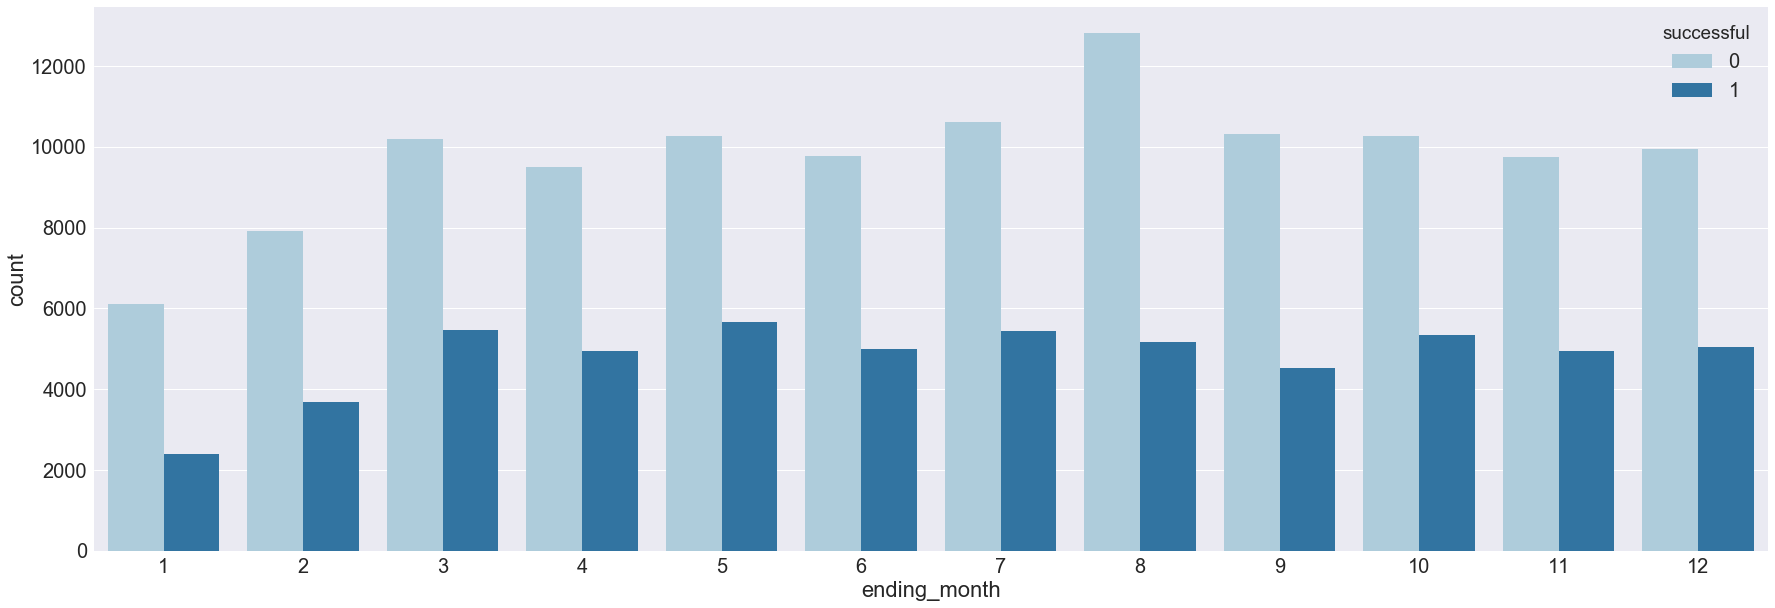

In [141]:
plt.figure(figsize=(30, 10))
sns.countplot(x='ending_month', data=ks, hue="successful", palette="Paired")

In [31]:
ks['freq_funding'] = ks.groupby('goal')['goal'].transform('count')

In [142]:
ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,successful,fund_time,title_length,starting_month,ending_month,freq_funding
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,0,30.041667,49,3,4,14712.0
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10 21:55:48,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,0,30.000000,57,7,8,396.0
10,100004721,Of Jesus and Madmen,Nonfiction,Publishing,CAD,2013-10-09 18:19:37,2500.0,2013-09-09 18:19:37,0.00,failed,0,CA,0.00,0,30.000000,19,9,10,5460.0
11,100005484,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08 06:42:58,12500.0,2013-03-09 06:42:58,12700.00,successful,100,US,12700.00,1,30.000000,16,3,4,624.0
12,1000055792,The Cottage Market,Crafts,Crafts,USD,2014-10-02 17:11:50,5000.0,2014-09-02 17:11:50,0.00,failed,0,US,0.00,0,30.000000,18,9,10,14712.0


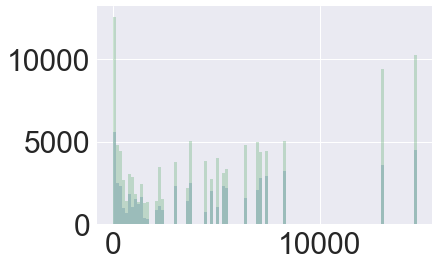

In [33]:
ks[ks.successful == 1]['freq_funding'].hist(bins=100, alpha=0.3)
ks[ks.successful == 0]['freq_funding'].hist(bins=100, alpha=0.3)

In [34]:
ks['currency'].nunique()

14

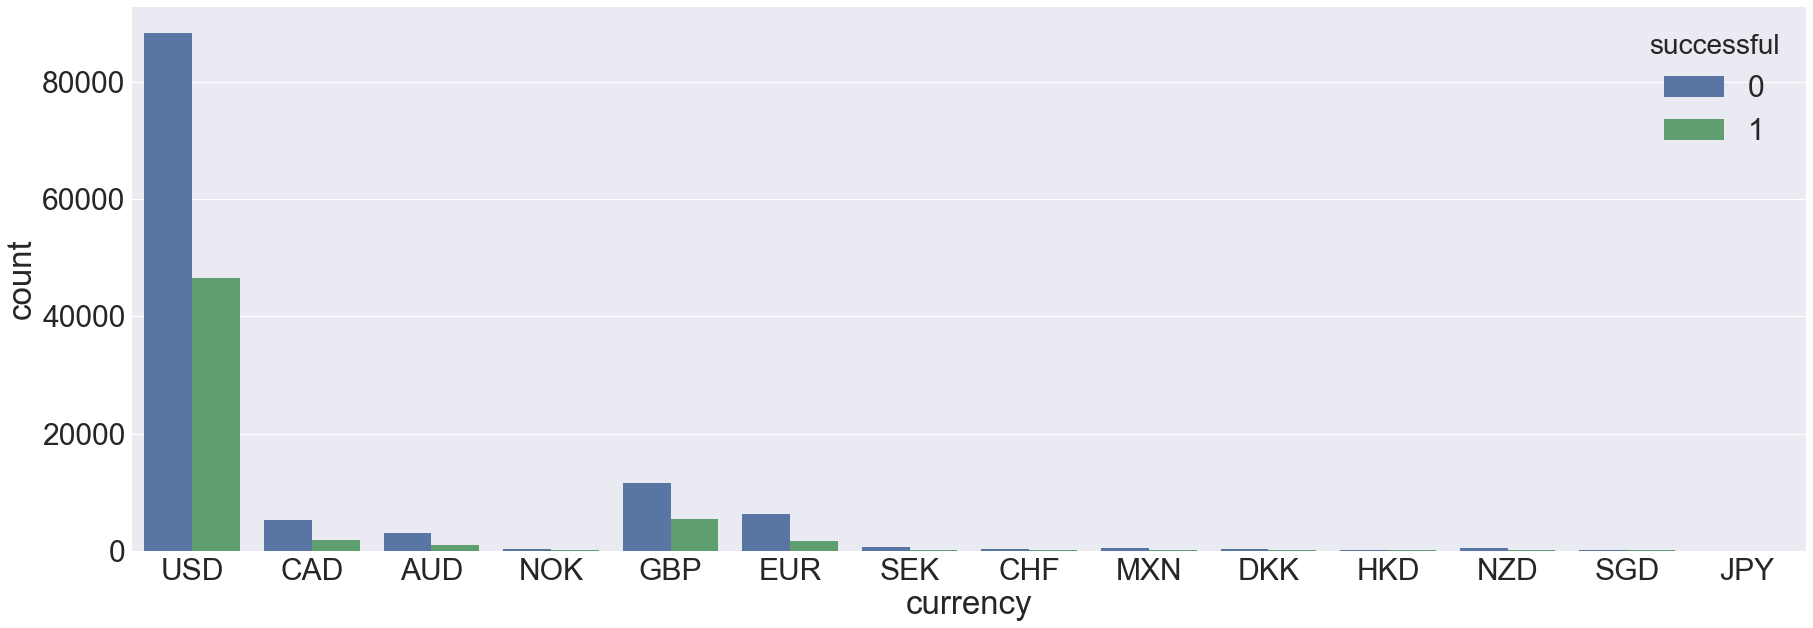

In [35]:
plt.figure(figsize=(30, 10))
sns.countplot(x="currency", data=ks, hue="successful")

In [139]:
ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,successful,fund_time,title_length,starting_month,ending_month,freq_funding
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,0,30.041667,49,3,3,14712.0
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10 21:55:48,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,0,30.000000,57,7,7,396.0
10,100004721,Of Jesus and Madmen,Nonfiction,Publishing,CAD,2013-10-09 18:19:37,2500.0,2013-09-09 18:19:37,0.00,failed,0,CA,0.00,0,30.000000,19,9,9,5460.0
11,100005484,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08 06:42:58,12500.0,2013-03-09 06:42:58,12700.00,successful,100,US,12700.00,1,30.000000,16,3,3,624.0
12,1000055792,The Cottage Market,Crafts,Crafts,USD,2014-10-02 17:11:50,5000.0,2014-09-02 17:11:50,0.00,failed,0,US,0.00,0,30.000000,18,9,9,14712.0
